# Chapter 6 Exercises

In [98]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import itertools

In [2]:
quakes = pd.read_csv("./data/earthquakes.csv")

In [3]:
covid = pd.read_csv("./data/covid19_cases.csv").assign(date = lambda x: pd.to_datetime(x.dateRep, format = "%d/%m/%Y")).set_index('date')

In [4]:
fb = pd.read_csv("./data/fb_stock_prices_2018.csv").assign(date = lambda x: pd.to_datetime(x.date, format = "%Y-%m-%d")).set_index('date')

1. Using `seaborn`, create a heatmap to visualize the correlation coefficients between earthquake magnitude and whether there was a tsunami for earthquakes measured with the `mb` magnitude type.

Text(0.5, 1.0, 'Correlations between magnitude and tsunami occurence\n for earthquakes with the mb magnitude type')

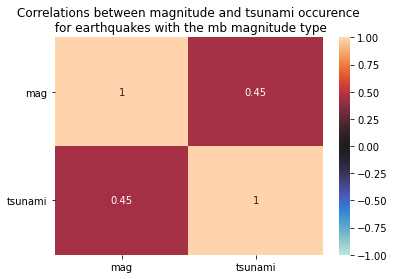

In [5]:
sns.heatmap(quakes[quakes.magType == 'mb'][['mag', 'tsunami']].corr(), annot = True, center = 0, vmin = -1, vmax = 1)
plt.yticks(rotation = 0)
plt.title('Correlations between magnitude and tsunami occurence\n for earthquakes with the mb magnitude type')

2.  Create a box plot of Facebook volume traded and closing prices, and draw reference lines for the bounds of a Tukey fence with a multiplier of 1.5. The bounds will be at $Q_1 − 1.5 × IQR$ and $Q_3 + 1.5 × IQR$. Be sure to use the `quantile()` method on the data to make this easier. (Pick whichever orientation you prefer for the plot, but make sure to use subplots.)

In [6]:
subset = fb[['volume', 'close']]
quantiles = subset.quantile([0.75, 0.25])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]
quantiles.loc['lower',:] = quantiles.loc[0.25,:] - 1.5 * quantiles.loc['iqr',:]
quantiles.loc['upper',:] = quantiles.loc[0.75,:] + 1.5 * quantiles.loc['iqr',:]

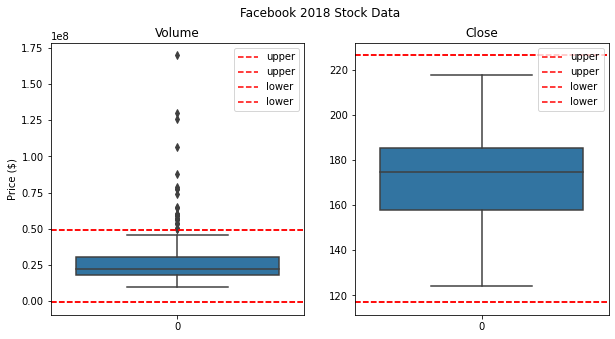

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sns.boxplot(data = subset.volume, ax = ax[0])
sns.boxplot(data = subset.close, ax = ax[1])
fig.suptitle('Facebook 2018 Stock Data')
ax[0].title.set_text('Volume')
ax[0].set_ylabel('Price ($)')
ax[1].title.set_text('Close')

for ax, col in zip(ax, ['volume', 'close']):
    for label in ['upper', 'lower']:
        ax.axhline(y = quantiles[col][label], color = 'r', linestyle = '--', label = label)
        ax.axhline(y = quantiles[col][label], color = 'r', linestyle = '--', label = label)
    ax.legend()
# ax[0].axhline(y = quantiles.volume.upper, color='r', linestyle='--', label = 'upper')
# ax[0].axhline(y = quantiles.volume.lower, color='r', linestyle='--', label = 'lower')
# ax[0].legend()

# ax[1].axhline(y = quantiles.close.upper, color='r', linestyle='--', label = 'upper')
# ax[1].axhline(y = quantiles.close.lower, color='r', linestyle='--', label = 'lower')
# ax[1].legend()

3. Plot the evolution of cumulative COVID-19 cases worldwide, and add a dashed vertical line on the date that it surpassed 1 million. Be sure to format the tick labels on the *y*-axis accordingly.

In [8]:
cumulative = covid.cases.groupby('date').sum().cumsum()

In [9]:
milliondate = cumulative.sub(1000000).abs().idxmin()

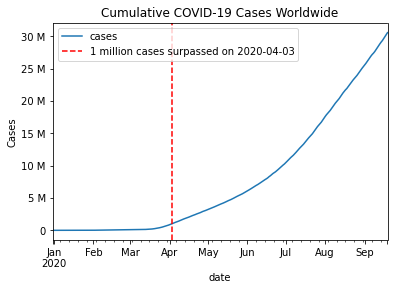

In [10]:
fig, ax = plt.subplots()
cumulative.plot(kind = 'line', axes = ax)
plt.axvline(x = milliondate, color ='r', linestyle = '--', label = f"1 million cases surpassed on {milliondate.strftime('%Y-%m-%d')}")
plt.legend()
plt.title('Cumulative COVID-19 Cases Worldwide')
plt.ylabel('Cases')
ax.yaxis.set_major_formatter(EngFormatter())

4. Use `axvspan()` to shade a rectangle from `'2018-07-25'` to `'2018-07-31'`, which marks the large decline in Facebook price on a line plot of the closing price.

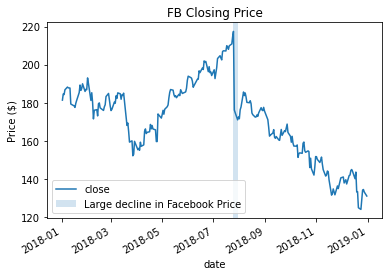

In [16]:
ax = fb.close.plot(title = 'FB Closing Price', ylabel = 'Price ($)')
start = pd.to_datetime('2018-07-25', format = '%Y-%m-%d')
end = pd.to_datetime('2018-07-31', format = '%Y-%m-%d')
ax.axvspan(start, end, alpha = 0.2, label = 'Large decline in Facebook Price')
ax.legend()

5. Using the Facebook stock price data, annotate the following three events on a line plot of the closing price:
   1. **Disappointing user growth announced after close** on July 25, 2018
   2. **Cambridge Analytica story breaks** on March 19, 2018 (when it affected the market)
   3. **FTC launches investigation** on March 20, 2018

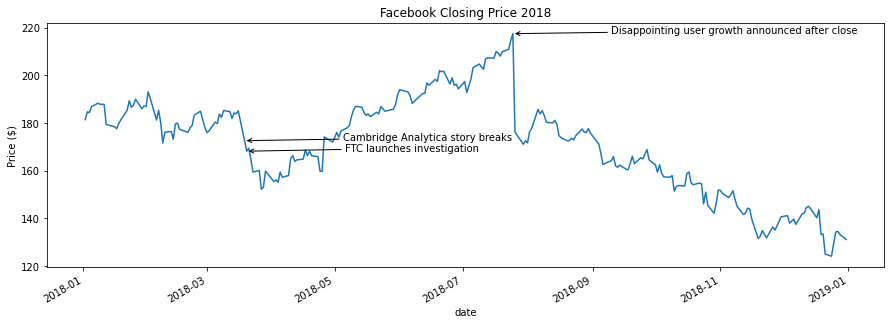

In [88]:
ax = fb.close.plot(title = 'Facebook Closing Price 2018', ylabel = 'Price ($)', figsize = (15,5))
dates = ['2018-07-25', '2018-03-19', '2018-03-20']
events = ['Disappointing user growth announced after close', 'Cambridge Analytica story breaks', 'FTC launches investigation']
close = fb.close[dates]

for date, event, close in zip(dates, events, close):
    datebuffer = pd.Timedelta(days = 47)
    date = pd.to_datetime(date, format = '%Y-%m-%d')
    plt.annotate(event, xytext = (date+datebuffer, close), xy = (date, close), arrowprops = {'arrowstyle': '->'})
#for key, value in events.items():
#    print(key, value)

6. Modify the `reg_resid_plots()` function to use a `matplotlib` colormap instead of cycling between two colors. Remember, for this use case, we should pick a qualitative colormap or make our own.

In [94]:
from matplotlib import cm

In [127]:
def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals plots
    side-by-side for every permutation of 2 columns in the data.
    
    Parameters:
        - data: A `pandas.DataFrame`

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(permutation_count, 2, figsize=(15, 8))
    
    colormap = cm.Set1(np.linspace(0,1,permutation_count))

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        #itertools.cycle(['royalblue', 'darkorange'])
        itertools.cycle(colormap)
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)

            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')
    return fig.axes

In [128]:
fb_reg_data = fb.assign(
    log_volume = np.log(fb.volume),
    max_abs_change = fb.high - fb.low).iloc[:,-2:]

[<AxesSubplot:xlabel='log_volume', ylabel='max_abs_change'>,
 <AxesSubplot:xlabel='log_volume', ylabel='residuals'>,
 <AxesSubplot:xlabel='max_abs_change', ylabel='log_volume'>,
 <AxesSubplot:xlabel='max_abs_change', ylabel='residuals'>]

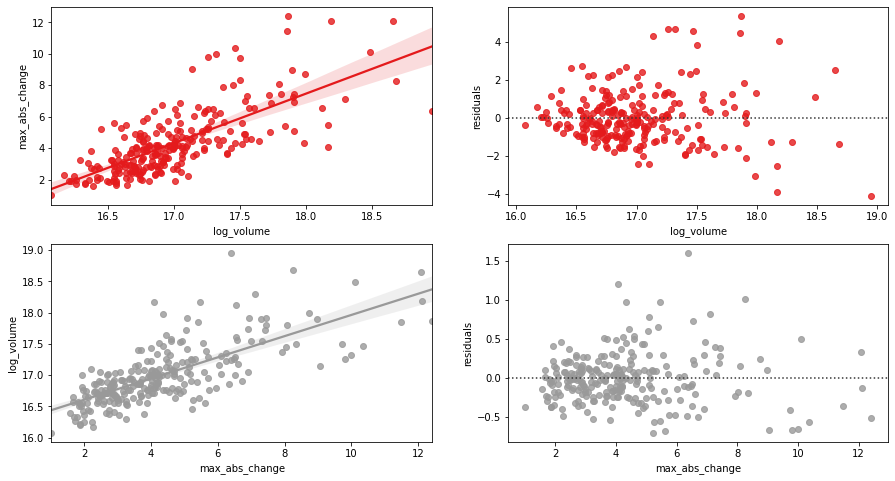

In [130]:
reg_resid_plots(fb_reg_data)